# Naïve Bayes Implementation

Oscar Contreras Carrasco

We are now going to implement Naïve Bayes in Python! For our implementation, we are going to use the MNIST dataset of handwritten numbers. I hope you find this material useful. Feel free to approach to me in case you have any questions or comments.

Let's first import our libraries



In [0]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2

Now we are going  to prepare our dataset. The Keras library already ships with MNIST and we can easily make use of it. In general, the dataset has 60,000 images for training and 10,000 for testing.

However, as part of our pre-processing, we are also applying HOG descriptors to our images. This will enhance prediction performance and will reduce the number of total features to evaluate. You can find out more about HOG features using OpenCV at https://docs.opencv.org/3.4.6/d5/d33/structcv_1_1HOGDescriptor.html

In [0]:
dataset = keras.datasets.mnist

(X_raw_train, y_train), (X_raw_test, y_test) = dataset.load_data()

X_train = np.zeros((X_raw_train.shape[0], 108))
X_test = np.zeros((X_raw_test.shape[0], 108))

hog = cv2.HOGDescriptor((28, 28), (14, 14), (7, 7), (14, 14), 12)

for n in range(X_raw_train.shape[0]):
    X_train[n] = hog.compute(X_raw_train[n]).reshape(1, -1)
    
for n in range(X_raw_test.shape[0]):
    X_test[n] = hog.compute(X_raw_test[n]).reshape(1, -1)

Now let's display some images from our dataset! All images are grayscale and 28x28

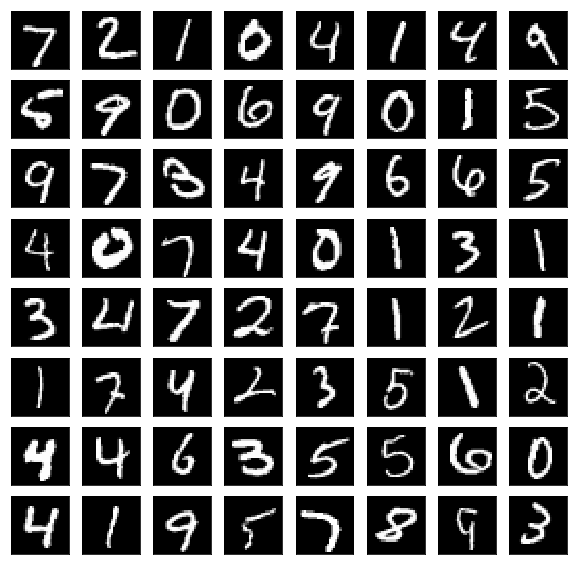

In [0]:
_, ax = plt.subplots(8, 8, figsize=(10, 10))
index = 0

for i in range(8):
    for j in range(8):
        cell = ax[i][j]
        cell.set_xticks([])
        cell.set_yticks([])
        cell.grid(False)
        cell.imshow(X_raw_test[index], cmap='gray')
        index += 1
        
plt.show()

Now let's calculate the prior probability $p(\mathbf y)$. This will actually be a vector containing the probabilities of occurrence for each class in our dataset. That is, the numbers from 0 to 9.

In [0]:
_, prob_y = np.unique(y_train, return_counts=True)
prob_y = prob_y / len(y_train)
num_classes = len(prob_y)
prob_y

array([0.09871667, 0.11236667, 0.0993    , 0.10218333, 0.09736667,
       0.09035   , 0.09863333, 0.10441667, 0.09751667, 0.09915   ])

Let's now calculate the Log of the Gaussian likelihood. We can use the following equation:

\begin{equation}
\large
\ln\mathcal N(\mathbf x;\mu,\sigma)=\sum_{i=1}^D\ln\sigma_i-\frac 1 2 \sum_{i=1}^D \left(\frac {x_i-\mu_i}{\sigma_i}\right)^2
\end{equation}

In [0]:
def log_gaussian(X, mu, sigma):
    return -(np.sum(np.log(sigma)) + 0.5 * np.sum(((X - mu) / sigma) ** 2)).reshape(-1, 1)

The following function allows us to train our model. This process is all about finding the class-level means $\mu$ and standard deviations $\sigma$. Once we know these parameters, then we can easily calculate the predictions by replacing their values in the Gaussian density function.

In [0]:
def train_naive_bayes():
    means = np.zeros((num_classes, X_train.shape[1]), dtype=np.float64)
    stdevs = np.zeros((num_classes, X_train.shape[1]), dtype=np.float64)
    
    for k, y_k in enumerate(np.unique(y_train)):
        indices = np.where(y_k == y_train)
        means[k] = np.mean(X_train[indices], axis=0)
        stdevs[k] = np.std(X_train[indices], axis=0)
        
    return means, stdevs

Now let's train our model! At this point, we will also display the class-level mean and covariance for the first category of our dataset.

In [0]:
means, stdevs = train_naive_bayes()
print('Means for class 0:\n', means[0], '\n\nStandard deviations for class 0\n', stdevs[0])

Means for class 0:
 [0.30678743 0.39533906 0.49698065 0.47942126 0.23345504 0.16344804
 0.09279153 0.01742686 0.01565332 0.01517458 0.01731597 0.17423633
 0.44260052 0.43626217 0.43094108 0.29247752 0.06933765 0.05582165
 0.04511124 0.02725237 0.06435403 0.12624306 0.15242024 0.3932381
 0.33039128 0.15454434 0.12076002 0.07976528 0.09248541 0.24739966
 0.29079921 0.26497931 0.36151173 0.36524211 0.31475686 0.3574081
 0.17230083 0.19654137 0.36610455 0.38814007 0.32552076 0.35568275
 0.32603948 0.18848521 0.22032257 0.17830103 0.092407   0.14042486
 0.32399185 0.33429498 0.39768063 0.37237062 0.24249547 0.23246207
 0.18654091 0.0988651  0.13513616 0.15262434 0.13333062 0.26915728
 0.10747293 0.10649556 0.29421138 0.40128702 0.39745421 0.41461391
 0.38427027 0.18927837 0.19220744 0.12930194 0.06576277 0.09647302
 0.27370977 0.08789382 0.09359048 0.11626488 0.10110692 0.23180832
 0.27630185 0.25474979 0.37876405 0.39644995 0.34596988 0.34044592
 0.42185483 0.37627579 0.37949988 0.26628861

The following function allows us to make predictions based on our parameters just found.

In [0]:
def predict(x):
    return np.argmax([np.log(prob_y[k]) + log_gaussian(x.reshape(1, -1), 
                      means[k], stdevs[k]) for k in range(num_classes)])

Now let's find the accuracy of our model by predicting the __y__ value for each image in our dataset. This will be 91.5% which is just fine. That means that even with the independence assumption we can get good prediction results. 

In [0]:
y_pred = np.zeros((X_test.shape[0]))

for n in range(X_test.shape[0]):
    y_pred[n] = predict(X_test[n])

accuracy_score(y_test, y_pred)

0.9151

Let's now display some items from the testing dataset with their corresponding predictions.

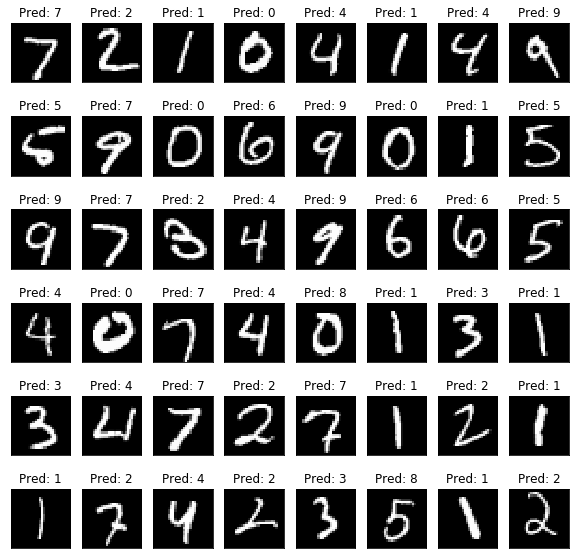

In [0]:
_, ax = plt.subplots(6, 8, figsize=(10, 10))
index = 0

for i in range(6):
    for j in range(8):
        cell = ax[i][j]
        cell.set_title('Pred: %s' % predict(X_test[index]))
        cell.set_xticks([])
        cell.set_yticks([])
        cell.grid(False)
        cell.imshow(X_raw_test[index], cmap='gray')
        index += 1
        
plt.show()

Moving forward, we also compare our result with sklearn's. In this case, we obtain exactly the same accuracy value of 91.5%

In [0]:
from sklearn.naive_bayes import GaussianNB

In [0]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9151